In [1]:
import imp
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

Import the specific Mobius "Sediment oxygen" model:

In [2]:
wrapper_fpath = (r'../../PythonWrapper/mobius.py')
mobius = imp.load_source('mobius', wrapper_fpath)

calib_fpath = (r'../../PythonWrapper/mobius_calib_uncert_lmfit.py')
calib = imp.load_source('calib', calib_fpath)

mobius.initialize(r'sedimentoxygen.dll')   #Linux: use r'./sedimentoxygen.so'

Set up a "data set" object containing parameters and results of this session

In [3]:
dataset = mobius.DataSet.setup_from_parameter_and_input_files('testparameters.dat', 'testinputs.dat')

water_sed_idx = dataset.get_parameter_uint('Upper layer of production zone', [])
z_resolution  = dataset.get_parameter_double('Z resolution', [])


nlevels = 102
ntime  = 40     #How many of the last time steps of the model run do we want to look at when doing processing?

Set up a function that runs the model with a specific temperature and returns the result data. It also returns the time index (relative to the data block) of the time when the sediment-oxygen interface is at its max and min values

In [4]:
def run_scenario(temperature=10.0, ppO2=21) :
    dataset.set_parameter_double('Temperature', [], temperature)
    dataset.set_parameter_double('Atmospheric O2 partial pressure', [], ppO2)
    dataset.run_model()
    
    data = np.zeros([ntime, nlevels])
    
    for idx in range(0, nlevels):
        series = dataset.get_result_series('C%d'%idx, [])
        data[:,idx] = series[-ntime:]
        
    water_sed_interface_conc = data[:, water_sed_idx]
    minidx = np.argmin(water_sed_interface_conc)
    maxidx = np.argmax(water_sed_interface_conc)
    
    return data, minidx, maxidx

Set up a function that adds a profile plot of a data block to a plot axis

In [5]:
xrange = (np.array(range(0, nlevels)) - water_sed_idx + 0.5)*z_resolution

def plot_profiles(ax, data, minidx, maxidx, scenario):
    
    minprofile = data[minidx,:]
    maxprofile = data[maxidx,:]
    
    ax.plot(xrange, minprofile, label='oxygen profile (night), scenario %d' % scenario)
    ax.plot(xrange, maxprofile, label='oxygen profile (day), scenario %d' % scenario)

Run with two different temperatures and plot the result

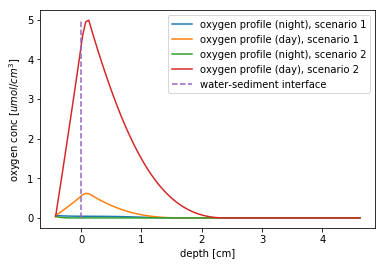

In [6]:
data1, minidx1, maxidx1 = run_scenario(5, 4)
data2, minidx2, maxidx2 = run_scenario(35, 4)


fig = plt.figure()
ax = fig.add_subplot(111)

plot_profiles(ax, data1, minidx1, maxidx1, 1)
plot_profiles(ax, data2, minidx2, maxidx2, 2)
ax.plot([0, 0], [0, np.amax(data2,axis=1)[maxidx2]], '--', label='water-sediment interface')

ax.set_xlabel('depth [cm]')
ax.set_ylabel('oxygen conc [$umol/cm^3$]')
ax.legend()

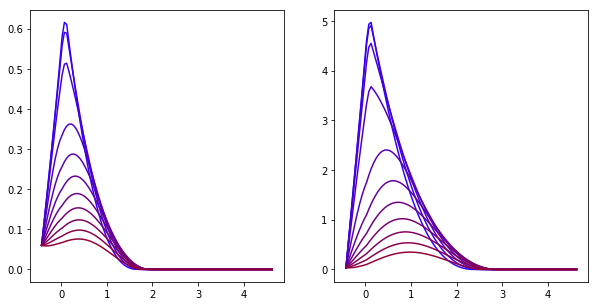

In [7]:
data, minidx, maxidx = run_scenario(5, 4)
fig = plt.figure(figsize = (10,5))
ax  = fig.add_subplot(121)
for i, idx in enumerate(range(maxidx-20, maxidx-20+11, 1)):
    profile = data[idx,:]
    ax.plot(xrange, profile, color = '#%02x%02x%02x' % (50+10*i, 0, 255-20*i))

data, minidx, maxidx = run_scenario(35, 4)
ax  = fig.add_subplot(122)
for i, idx in enumerate(range(maxidx-20, maxidx-20+11, 1)):
    profile = data[idx,:]
    ax.plot(xrange, profile, color = '#%02x%02x%02x' % (50+10*i, 0, 255-20*i))

Make a function that computes the penetration depths in a data block at a given time index

In [8]:
#The one to ‘oxic’ conditions at 65 um O2 l-1 (but this one will likely be higher than our highest estimates at 25% PAL).
#The one at ‘hypoxic’ conditions at 22 umol O2 l-1 (this one will likely be quite shallow in the sediment).
#The ‘zero’ at ne at <0.01 um O2 L-1. This one will be the most important.
oxic     = 65.0e-3   #Note: units in our data block are in umol/cm3, so have to convert from umol/l
hypoxic  = 22.0e-3
zeroconc = 2e-3

def compute_penetration_depth(data, timeidx):
    
    def depth_of_index(index) :
        return (index - water_sed_idx + 0.5)*z_resolution
        
    def linear_intersection(x0, x1, C0, C1, C):
        return (C-C0)*(x1-x0)/(C1-C0) + x0
    
    def depth_of_intersection(x0, x1, C0, C1, C):
        x = linear_intersection(x0, x1, C0, C1, C)
        return depth_of_index(x)
    
    oxicdepth = np.nan
    hypoxicdepth = np.nan
    zeroconcdepth = np.nan
    for x in range(water_sed_idx, nlevels) :
        x1 = x
        x0 = x-1
        C1 = data[timeidx, x1]
        C0 = C1
        if x > 0:
            C0 = data[timeidx,x0]
        
        if (np.isnan(oxicdepth)) and C1 < oxic :
            oxicdepth = depth_of_intersection(x0, x1, C0, C1, oxic)
        if (np.isnan(hypoxicdepth)) and C1 < hypoxic :
            hypoxicdepth = depth_of_intersection(x0, x1, C0, C1, hypoxic)
        if (np.isnan(zeroconcdepth)) and C1 < zeroconc :
            zeroconcdepth = depth_of_intersection(x0, x1, C0, C1, zeroconc)
        
        if oxicdepth < 0 : oxicdepth=0
        if hypoxicdepth < 0 : hypoxicdepth=0
        if zeroconcdepth < 0 : zeroconcdepth=0
        
    return oxicdepth, hypoxicdepth, zeroconcdepth

def print_penetration_depth(data, timeidx):
    oxicdepth, hypoxicdepth, zeroconcdepth = compute_penetration_depth(data, timeidx)
    print("Penetration depths:")
    #print("(nan values signify that the depth happens below %g cm)" % (100.0-water_sed_idx)*z_resolution)
    #print("(negative values may signify that the condition does not occur at all)")
    print("Oxic conditions above %g cm" % oxicdepth)
    print("Hypoxic conditions above %g cm" % hypoxicdepth)
    print("Severely hypoxic conditions above %g cm" % zeroconcdepth)

In [9]:
#daytime penetration depths
print("daytime penetration depth, scenario1:")
print_penetration_depth(data1, maxidx1)
print("")
print("daytime penetration depth, scenario2:")
print_penetration_depth(data2, maxidx2)
print("")
#nighttime
print("nighttime penetration depth, scenario1:")
print_penetration_depth(data1, minidx1)
print("")
print("nighttime penetration depth, scenario2:")
print_penetration_depth(data2, minidx2)

daytime penetration depth, scenario1:
Penetration depths:
Oxic conditions above 1.05601 cm
Hypoxic conditions above 1.28556 cm
Severely hypoxic conditions above 1.54854 cm

daytime penetration depth, scenario2:
Penetration depths:
Oxic conditions above 2.02336 cm
Hypoxic conditions above 2.16586 cm
Severely hypoxic conditions above 2.3167 cm

nighttime penetration depth, scenario1:
Penetration depths:
Oxic conditions above 0 cm
Hypoxic conditions above 0.923418 cm
Severely hypoxic conditions above 1.3856 cm

nighttime penetration depth, scenario2:
Penetration depths:
Oxic conditions above 0 cm
Hypoxic conditions above 0 cm
Severely hypoxic conditions above 0 cm


In [10]:
relative_to_depth = 5

def compute_average_depth(data, initialidx) :
    totox  = 0.0
    tothyp = 0.0
    totsev = 0.0
    for idx in range(initialidx, initialidx+20):
        oxicdepth, hypoxicdepth, zeroconcdepth = compute_penetration_depth(data, idx)
        #print('ox:%f hyp:%f zer:%f' % (oxicdepth, hypoxicdepth, zeroconcdepth))
        totox+=oxicdepth
        tothyp+=hypoxicdepth-oxicdepth
        totsev+=zeroconcdepth-hypoxicdepth
    totox/=20.0
    tothyp/=20.0
    totsev/=20.0
    
    return 100.0*(totox/relative_to_depth), 100.0*(tothyp/relative_to_depth), 100.0*(totsev/relative_to_depth)

def print_average_depth(data, initialidx):
    ox, hyp, sev = compute_average_depth(data, initialidx)
    print("average oxic: %f %%" % ox)
    print("average hypoxic: %f %%" % hyp)
    print("average severely hypoxic: %f %%" % sev)
    print("average anoxic: %f %%" % (100.0 - (sev+hyp+ox)) )
    print("")
#average penetration depths:

print("daily average intervals as %% of %gcm in scenario 1:" % relative_to_depth)
print_average_depth(data1, minidx1-20)

print("daily average intervals as %% of %gcm in scenario 2:" % relative_to_depth)
print_average_depth(data2, minidx2-20)

daily average intervals as % of 5cm in scenario 1:
average oxic: 18.327766 %
average hypoxic: 6.035622 %
average severely hypoxic: 6.136565 %
average anoxic: 69.500047 %

daily average intervals as % of 5cm in scenario 2:
average oxic: 34.299395 %
average hypoxic: 4.255221 %
average severely hypoxic: 2.828425 %
average anoxic: 58.616959 %



Make a function that 3d-plots a data block

In [11]:
def make_3d_plot(data) :
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')

    x = np.outer(np.ones(ntime), xrange)
    y = np.outer(range(0,ntime), np.ones(nlevels))

    cmap = 'cividis'
    offset = -50
    
    ax.plot_surface(x, y, data, cmap=cmap, shade=True, alpha=0.9)#, edgecolor='black')
    ax.contour(x, y, data, levels=[zeroconc, hypoxic, oxic], colors='k', linestyles='solid', linewidths=3.0)
    ax.contour(x, y, data, levels=[zeroconc, hypoxic, oxic], cmap=cmap, linestyles='solid', linewidths=3.0, offset=offset)
    #ax.set_title('Surface plot')
    ax.set_ylabel('time [h]')
    ax.set_xlabel('depth [cm]')
    ax.set_zlabel('oxygen conc [$umol/cm^3$]')
    
    ax.set_zlim(offset, 30)

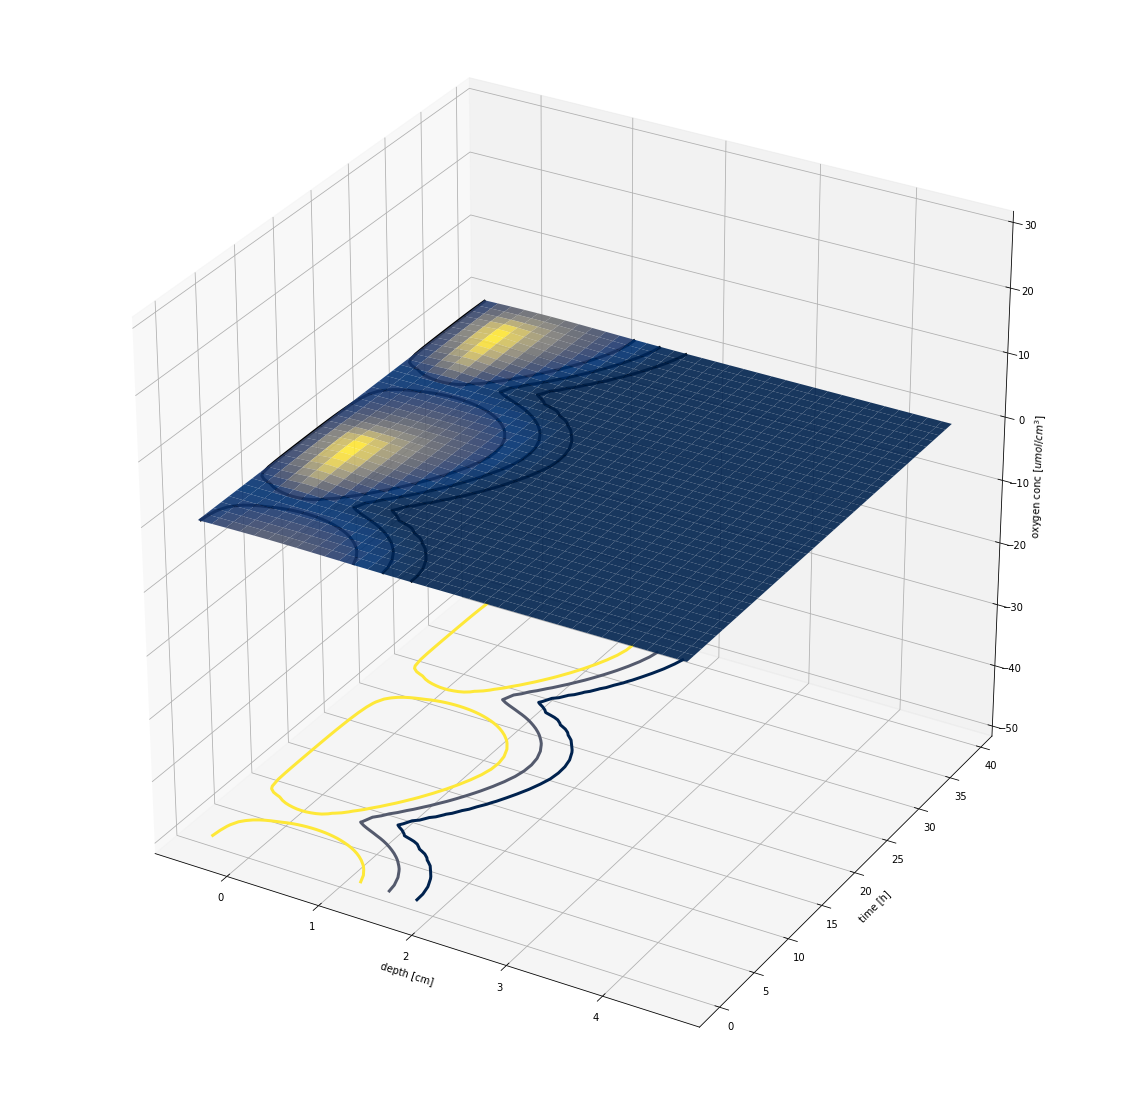

In [12]:
make_3d_plot(data1)

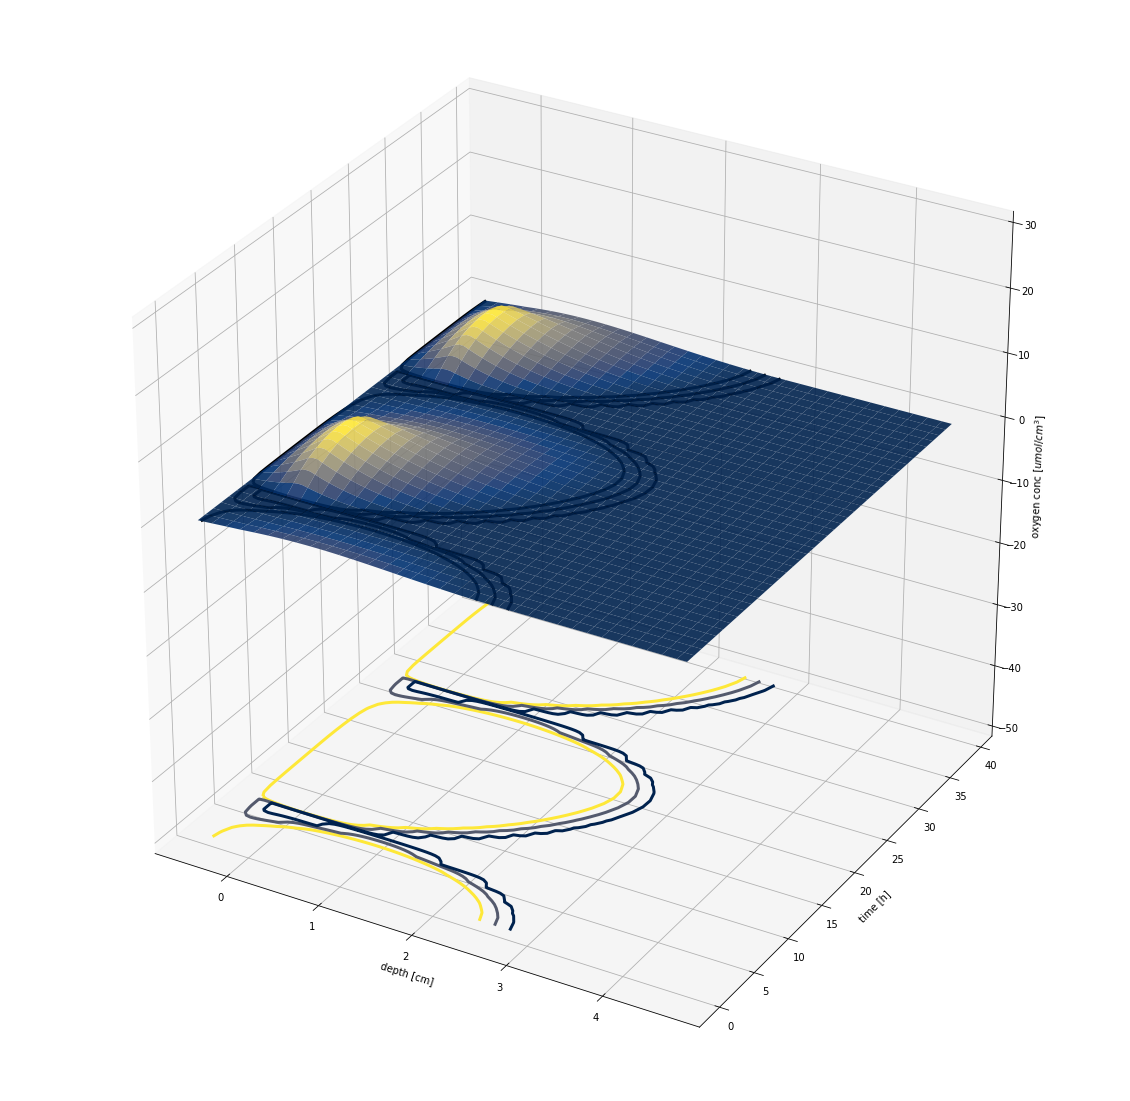

In [13]:
make_3d_plot(data2)